In [1]:
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import spacy
from spacy.training import Corpus

import os
import numpy as np

In [2]:
LEAST_CONF_MDIR = "runs/least_confidence_50i_50n_kpwr-full_1669041142f2942019/models"
LEAST_CONF_MNAMES = [
    "model_2it_97spans.spacy",
    "model_14it_1020spans.spacy",
    "model_27it_2016spans.spacy",
    "model_41it_3040spans.spacy"
]

In [3]:
RAND_MDIR = "./runs/random_50i_50n_kpwr-full_1669041088f13043/models"
RAND_MNAMES = [
    "model_2it_97spans.spacy",
    "model_14it_1023spans.spacy",
    "model_27it_2007spans.spacy",
    "model_40it_3005spans.spacy"
]

In [4]:
TEST_DB = "./data/inzynierka-kpwr-test-3-full.spacy"
_temp_nlp = spacy.load(os.path.join(RAND_MDIR, RAND_MNAMES[0]))
test_corpus = tuple(Corpus(TEST_DB)(_temp_nlp))

In [5]:
SPANS_KEY = "sc"
label_idxs = {"nam_liv_person": 0, "nam_loc_gpe_city": 1,
                "nam_loc_gpe_country": 2, "O": 3}
ticklabels = ["nam_liv_person", "nam_loc_gpe_city", "nam_loc_gpe_country", "O"]
short_labels = ["PERSON", "CITY", "COUNTRY", "O"]

def get_spans_confusion_matrix(test_corpus, predictions, spans_key, label_idxs):
    n_labels = len(label_idxs)
    cm = np.zeros(shape=(n_labels, n_labels))
    for actual, pred in zip(test_corpus, predictions):
        actual_spans = actual.to_dict()["doc_annotation"]["spans"]
        pred_spans = pred.spans
        if not actual_spans or not pred_spans:
            continue
        for actual_span in actual_spans[spans_key]:
            actual_label = actual_span[2]
            found = False
            for pred_span in pred_spans[spans_key]:
                if actual_span[0] == pred_span.start_char \
                        and actual_span[1] == pred_span.end_char:
                    pred_label = pred_span.label_
                    cm[label_idxs[actual_label]][label_idxs[pred_label]] += 1
                    found = True
            if not found:
                cm[label_idxs[actual_label]][label_idxs["O"]] += 1
    return cm

## Random sampling strategy

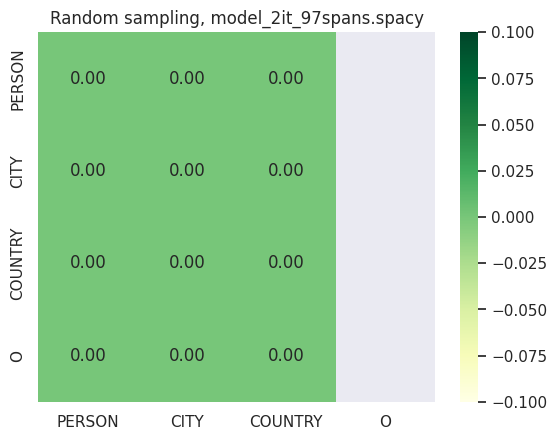

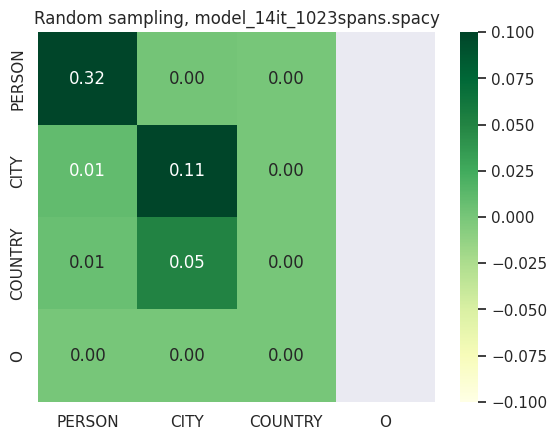

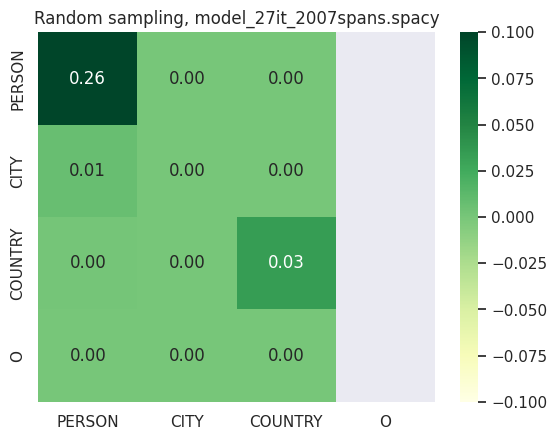

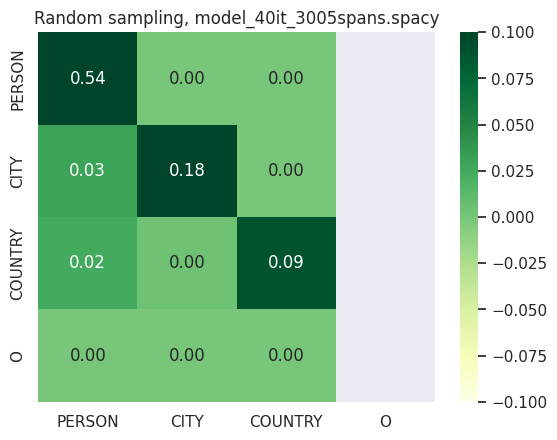

In [6]:
for rand_mname in RAND_MNAMES:
    rand_mpath = os.path.join(RAND_MDIR, rand_mname)
    rand_nlp = spacy.load(rand_mpath)
    texts = [example.text for example in test_corpus]
    predictions = rand_nlp.pipe(texts)
    rand_cm = get_spans_confusion_matrix(test_corpus, predictions,
                                         SPANS_KEY, label_idxs)
    rand_cm = rand_cm / rand_cm.sum(axis=1)

    sn.set(font_scale=1)
    hm = sn.heatmap(rand_cm, annot=True, cmap="YlGn", fmt="0.2f",
                    xticklabels=short_labels, yticklabels=short_labels
    )
    hm.set(title=f"Random sampling, {rand_mname}")
    plt.show()

# Least-confidence sampling strategy

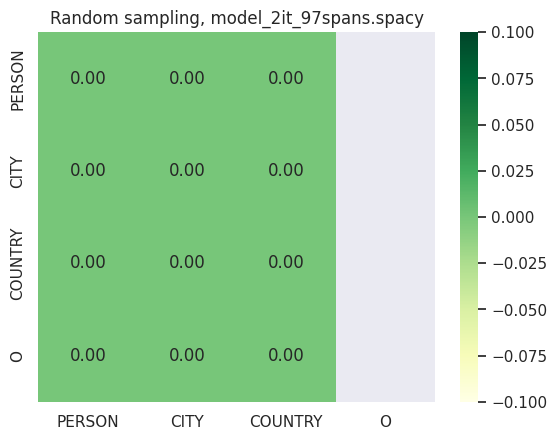

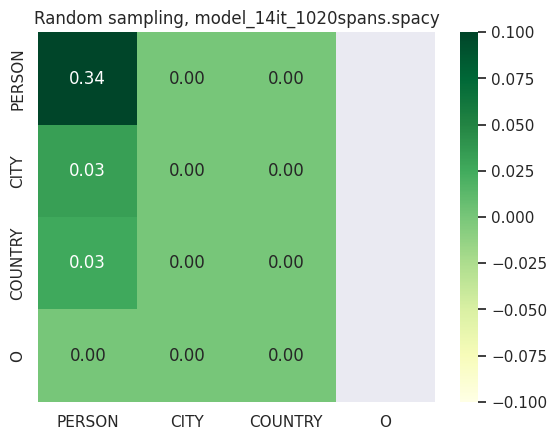

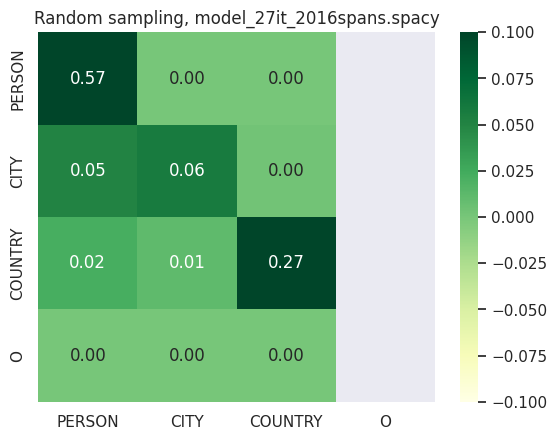

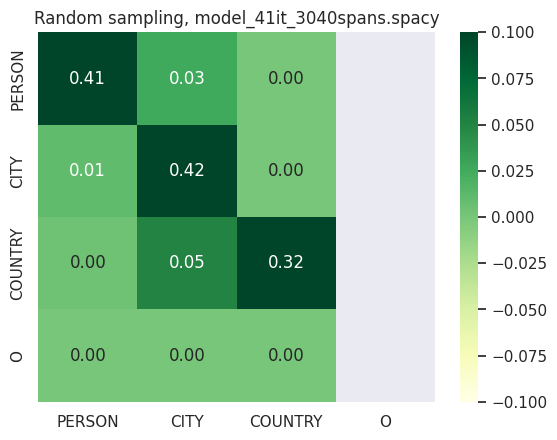

In [7]:
for lconf_mname in LEAST_CONF_MNAMES:
    lconf_mpath = os.path.join(LEAST_CONF_MDIR, lconf_mname)
    lconf_nlp = spacy.load(lconf_mpath)
    texts = [example.text for example in test_corpus]
    predictions = lconf_nlp.pipe(texts)
    lconf_cm = get_spans_confusion_matrix(test_corpus, predictions,
                                         SPANS_KEY, label_idxs)
    lconf_cm = lconf_cm / lconf_cm.sum(axis=1)

    sn.set(font_scale=1)
    hm = sn.heatmap(lconf_cm, annot=True, cmap="YlGn", fmt="0.2f",
                    xticklabels=short_labels, yticklabels=short_labels
    )
    hm.set(title=f"Random sampling, {lconf_mname}")
    plt.show()